In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from torch.distributions import Dirichlet, Normal
from src import loss_functions as LF
from src import deriv_2nd_R as DR

**The object of interest, $M$ is the expectation of a random matrix. So we generate some data to do Monte Carlo.**

In [104]:
p = 10

alpha = torch.ones(p, p, dtype= torch.float32) + torch.eye(p, dtype= torch.float32)*2
# alpha = torch.tensor([[10, 1, 1, 1], [1, 10, 1], [1, 1, 10]], dtype= torch.float64)
# alpha = torch.tensor([[5, 1]], dtype= torch.float64)
n= 30000
K, p = alpha.shape
# torch.manual_seed(5)
dir = Dirichlet(alpha)
X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :(p-1)].to("cuda")

**We first look at the our Mollified ReLU-Simplex Loss. It is known to be PD for the given data.**

Currently at 100.00%      

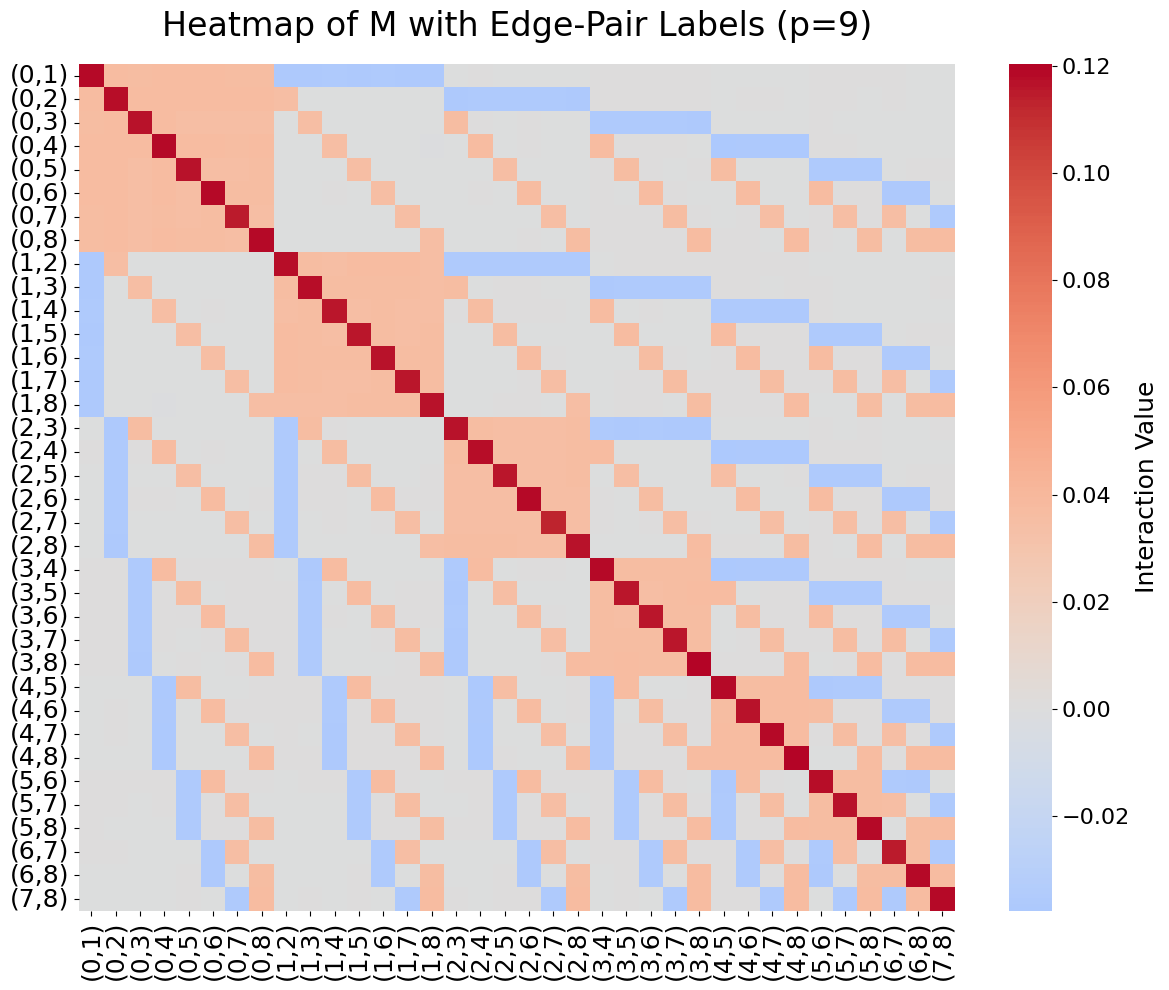

In [105]:
M = DR.construct_M_from_basis(LF.mollified_relu_simplex_core, X, 0.02, LF.mollified_relu_grad, LF.mollified_relu_hess)
# print(torch.tensor(verify_m_entries(X), device = "cuda")- M[1,1:3].to("cuda"))
DR.plot_M_heatmap(M, True)

**We then look at the Quadratic-Sum-Penalty Loss. It is known to be ND with certain parameters for the given data.**

Currently at 100.00%      

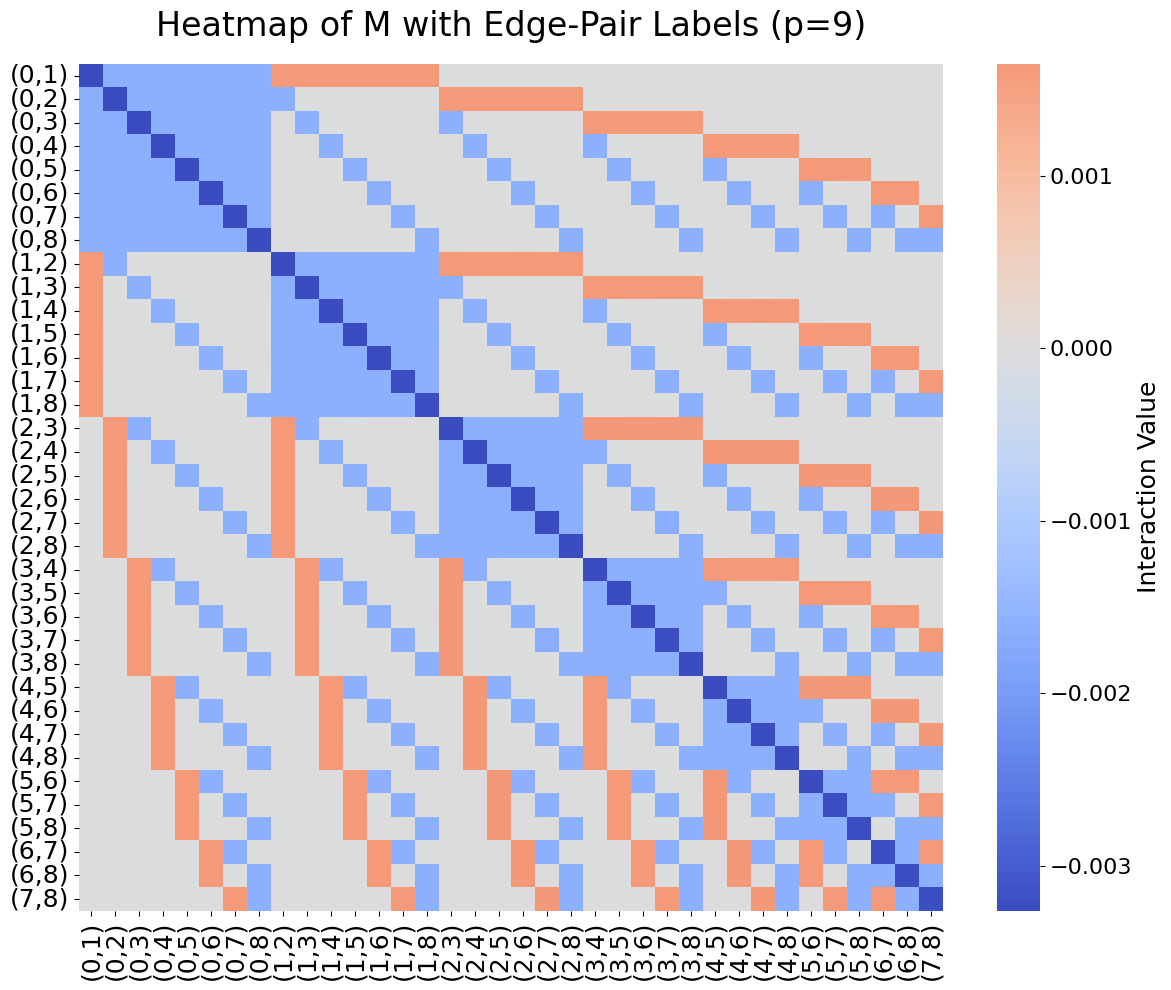

In [4]:
M_quad = DR.construct_M_from_basis(LF.quadratic_sum_penalty_core, X, -0.02)
DR.plot_M_heatmap(M_quad)

**Below we try to verify that the decomposition $\text{skew}(p) = \mathcal{U} \oplus \mathcal{U}^\perp$, and see if Schur's Lemma is applicable.**
1. We see from the block diagonalization that the eigenvalues of $M$ divides into $2$ groups. $\implies$ Schur's Lemma is applausible.
2. We hypothesize that $\mathcal{U}$, the standard representation of $S_p$, corresponds to one eigenspace of $M$. To test this, we construct a matrix $U$ spanning $\mathcal{U}$, project the eigenvectors of $M$ onto $\mathcal{U}^\perp$, and assess their alignment. $\implies$ Schur's Lemma seems to be right.

In [5]:
def block_diagonalize(M, num_top=None):
    """
    Diagonalize or block-structure a symmetric matrix M via eigendecomposition.

    Parameters:
        M (Tensor): Symmetric matrix (n x n)
        num_top (int): Optional. If provided, sorts eigenvectors so top `num_top` largest
                       eigenvalues come last (block-structured view)

    Returns:
        M_block (Tensor): Matrix in the eigenbasis
        Q (Tensor): Eigenvector matrix (columns are eigenvectors)
        eigvals (Tensor): Eigenvalues (in sorted order)
    """
    eigvals, Q = torch.linalg.eigh(M)
    
    if num_top is not None:
        # Reorder eigenvalues and eigenvectors to group top modes
        idx = torch.argsort(eigvals)  # ascending
        # move top `num_top` to the end
        if num_top > 0:
            idx = torch.cat([idx[:-num_top], idx[-num_top:]], dim=0)
        eigvals = eigvals[idx]
        Q = Q[:, idx]

    M_block = Q.T @ M @ Q  # should be diagonal or nearly block diagonal
    return M_block, Q, eigvals


def construct_node_flow_matrix(p):
    """
    Constructs the matrix U ∈ R^{binom(p,2) × p}, where each column u_i represents
    the node-based skew flow centered at node i in the B(i,j) basis.
    """
    edge_list = list(combinations(range(p), 2))  # ordered pairs (i < j)
    edge_to_index = {e: k for k, e in enumerate(edge_list)}  # map (i,j) to row index

    num_edges = len(edge_list)
    U = torch.zeros((num_edges, p))  # each column is a u_i

    for i in range(p):
        for j in range(p):
            if i == j:
                continue
            # Make sure we use (min, max) since B(i,j) = -B(j,i)
            e = tuple(sorted((i, j)))
            sign = 1 if i < j else -1  # account for antisymmetry
            row_idx = edge_to_index[e]
            U[row_idx, i] += sign

    return U, edge_list


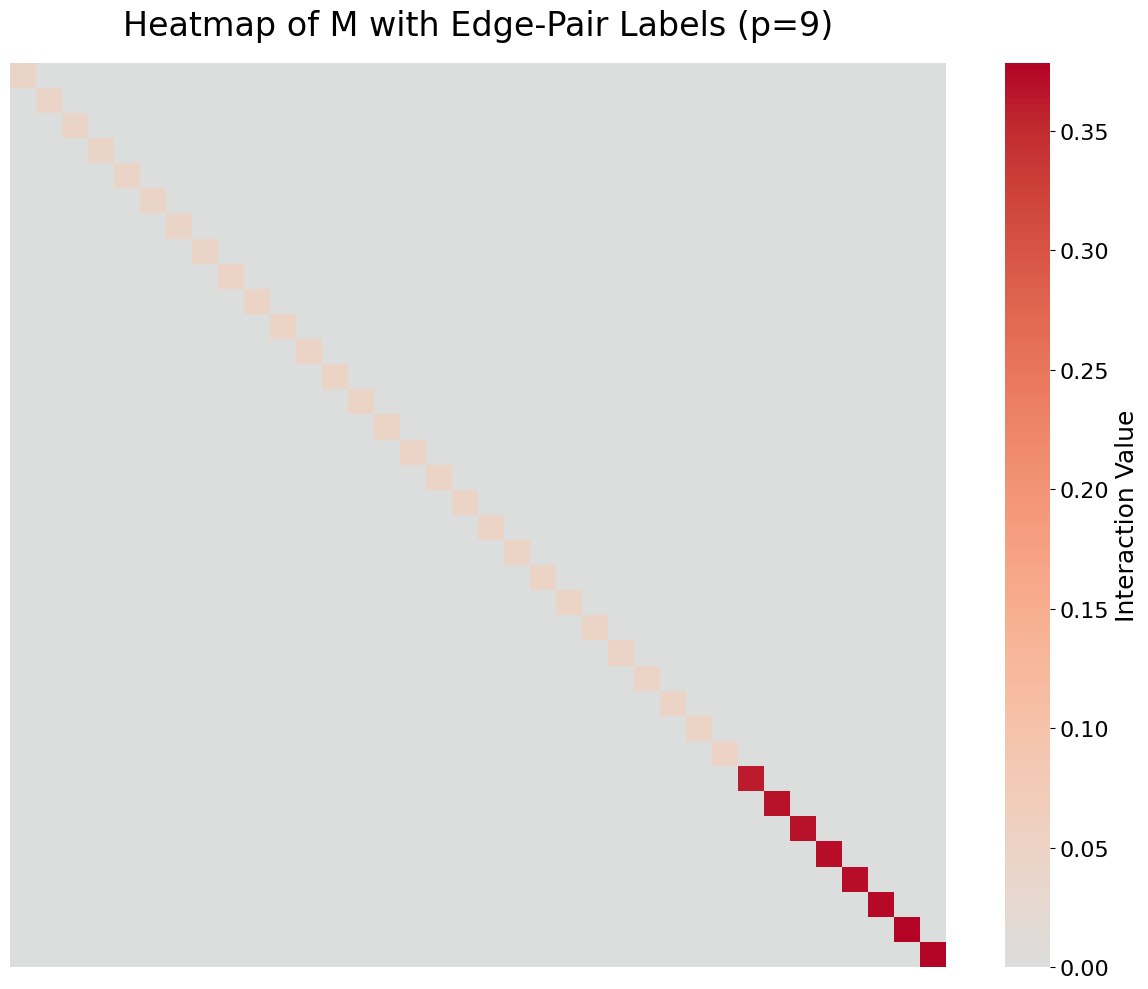

Residuals of Q_top outside skew-flow space: tensor([0.9998, 0.9882, 0.9758, 0.8979, 0.8995, 0.9798, 0.8893, 0.9856, 0.9999,
        0.9561, 0.9998, 0.9968, 1.0000, 0.9930, 0.9949, 0.9910, 0.9993, 0.9994,
        0.9866, 0.9938, 0.9836, 0.9801, 0.9995, 0.9947, 0.9988, 0.9997, 0.9985,
        1.0000, 0.0063, 0.0086, 0.0057, 0.0055, 0.0079, 0.0058, 0.0061, 0.0062],
       device='cuda:0')


In [6]:
M_block, Q, eigvals = block_diagonalize(M, num_top=p)  # p = the number of large-eigenvalue modes

DR.plot_M_heatmap(M_block, False)


U = construct_node_flow_matrix(p-1)[0]
P_orth, _ = torch.linalg.qr(U)  # Q ∈ R^{binom(p,2) × p}, orthonormal columns
P = (P_orth @ P_orth.T).to("cuda")  # projection onto the column space of Q = U
# Q_top = Q[:, -(p-2):]  # shape: [dim, num_top]
Q_top = Q
residuals = torch.norm((torch.eye(P.shape[0], device=P.device) - P) @ Q_top, dim=0)
print("Residuals of Q_top outside skew-flow space:", residuals)


**Checking Computation of $d,\ \kappa$:**
1. Since $\text{skew}(p) = \mathcal{U} \oplus \mathcal{U}^\perp$ is true, we can verify $M \succ 0$ by checking $u^TMu>0$ and $v^TMv > 0$ for one $u \in \mathcal{U}$ and one $v \in \mathcal{U}^\perp$.
2. We pick $u = \sum\limits_{j = 2}^{p}B(1, j)$, and $v = B(1,2) - B(1, p) + B(2, p)$
3. After some derivation, we get $u^TMu \propto d + (p-2)\kappa$, and $v^TMv \propto d - 2\kappa$, where $d$ is the diagonal entry of $M$ and $\kappa$ is the non-zero off-diagonal entry.
4. So we verify that our formula for $d,\ \kappa$ is correct by checking if $d = M_{11},\ \kappa = M_{12}$ 

In [35]:
def verify_m_entries(Y, grad_fn, hess_fn, sigma=0.02):
    """
    Compare manual RHS expressions for M_{(12,12)} and M_{(12,13)} 
    with values in matrix M, using mollified gradient and Hessian.
    
    Y: (n, p) tensor
    Returns: tuple (d_manual, kappa_manual)
    """
    if Y.ndim == 1:
        Y = Y.unsqueeze(0)
    n, p = Y.shape

    grad = grad_fn(Y, sigma=sigma, reduction=None)  # (n, p)
    hess = hess_fn(Y, sigma=sigma, reduction=None)  # (n, p, p)

    y1, y2, yp = Y[:, 0], Y[:, 1], Y[:, p-1]
    g1, g2 = grad[:, 0], grad[:, 1]
    h11 = hess[:, 0, 0]
    h12 = hess[:, 0, 1]
    h21 = hess[:, 1, 0]
    h22 = hess[:, 1, 1]

    ### RHS for M_{(12,12)}:
    term_d = y1 * (y1 * h22 - y2 * h12 - g1)  # shape (n,)
    d_manual = term_d.mean()

    ### RHS for M_{(12,13)}:
    term_kappa = yp * (y2 * h11 + (yp - 2 * y1) * h21 - g2)  # shape (n,)
    kappa_manual = 0.5 * term_kappa.mean()

    return torch.stack([d_manual, kappa_manual])


def mollified_nonneg_simplex_core(x, sigma):
    """
    Smooth version of the ReLU simplex loss using smoothed ReLU.

    Args:
        x: (n, p) tensor
        sigma: smoothing parameter (float or tensor)

    Returns:
        Tensor of shape (n,) with smoothed loss values
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    
    n, p = x.shape
    sigma = torch.as_tensor(sigma, dtype=x.dtype, device=x.device)
    p = torch.tensor(p, device=x.device)
    
    # Negative entries penalty
    neg_part = LF.smoothed_relu(-x, sigma).sum(dim=1)

    return neg_part

In $2$-D, $\kappa$ is exactly half of $d$, since $M$ is $1 \times 1$. 

In [91]:
sigma = 0.2
X = torch.ones(10, 2, device="cuda")/3

M = DR.construct_M_from_basis(mollified_nonneg_simplex_core, X, sigma)
d_kappa = verify_m_entries(X, LF.mollified_relu_nonneg_grad, LF.mollified_relu_nonneg_hess, sigma).cpu()

M11_M12 = M[0, 0:2].cpu()
print(f"F-Distance between (d) and (M_11) is {torch.norm(d_kappa[0] - M11_M12): .4f}.")
print(f"d = {d_kappa[0].item(): .4f}")

Currently at 100.00%      F-Distance between (d) and (M_11) is  0.0000.
d =  0.0712


In [97]:
sigma = 0.2
X = torch.ones(10, 3, device="cuda")/3

M = DR.construct_M_from_basis(mollified_nonneg_simplex_core, X, sigma)
d_kappa = verify_m_entries(X, LF.mollified_relu_nonneg_grad, LF.mollified_relu_nonneg_hess, sigma).cpu()

M11_M12 = M[0, 0:2].cpu()

print(f"F-Distance between (d, kappa) and (M_11, M_12) is {torch.norm(d_kappa - M11_M12): .4f}.")
print(f"d = {d_kappa[0].item(): .4f}, kappa = {d_kappa[1].item(): .4f}")

print(torch.linalg.eigvalsh(M))

Currently at 100.00%      F-Distance between (d, kappa) and (M_11, M_12) is  0.0000.
d =  0.0712, kappa =  0.0356
tensor([-3.1827e-09,  1.0679e-01,  1.0679e-01], device='cuda:0')


$\kappa = \frac{1}{2}\mathbb{E} \left[ y_p\left(y_1\frac{1}{\sigma}\phi\left( \frac{y_2}{\sigma} \right) + \Phi\left( -\frac{y_2}{\sigma} \right) \right)\right]$ 

$d = \mathbb{E}\left[ y_1^2\phi\left( \frac{y_2}{\sigma} \right) + y_1\frac{1}{\sigma}\Phi\left( -\frac{y_1}{\sigma} \right)\right]$

It is possible that the local minimality of our loss function depends on the distribution of $y$, if we only enforce the exchangeable condition.

For example, if we consider a point mass distribution on $\frac{1}{p}\mathbf{1}_p$, then $y_1 = y_2 = y_p$, and we see that

$d = 2\kappa = \mathbb{E}\left[ y^2\phi\left( \frac{y}{\sigma} \right) + y\frac{1}{\sigma}\Phi\left( -\frac{y}{\sigma} \right)\right]$.

It should be clear that $d \not > 2\kappa$ in this case.

In [101]:
p = 4

alpha = torch.ones(p, p, dtype= torch.float32) + torch.eye(p, dtype= torch.float32)*2
# alpha = torch.tensor([[10, 1, 1, 1], [1, 10, 1], [1, 1, 10]], dtype= torch.float64)
# alpha = torch.tensor([[5, 1]], dtype= torch.float64)
n= 30000
K, p = alpha.shape
# torch.manual_seed(5)
dir = Dirichlet(alpha)
X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :(p-1)].to("cuda")

M = DR.construct_M_from_basis(mollified_nonneg_simplex_core, X, sigma)
d_kappa = verify_m_entries(X, LF.mollified_relu_nonneg_grad, LF.mollified_relu_nonneg_hess, sigma).cpu()

M11_M12 = M[0, 0:2].cpu()
print(f"F-Distance between (d) and (M_11) is {torch.norm(d_kappa - M11_M12): .4f}.")
print(f"d = {d_kappa[0].item(): .4f}, kappa = {d_kappa[1].item(): .4f}")

print(torch.linalg.eigvalsh(M))

Currently at 100.00%      F-Distance between (d) and (M_11) is  0.0002.
d =  0.1747, kappa =  0.0641
tensor([0.0458, 0.2376, 0.2394], device='cuda:0')


In [99]:
u = torch.tensor([1, -2], dtype=torch.float32)
u_perp = torch.tensor([1, p-2], dtype=torch.float32)

print(f"d - 2k ={(u @ d_kappa).item(): .4f}, d + (p - 2)k ={(u_perp @ d_kappa).item(): .4f}.")

d - 2k = 0.0460, d + (p - 2)k = 0.3024.


In [118]:
sigma = 0.2
X = torch.ones(10, 3, device="cuda")/5

M = DR.construct_M_from_basis(LF.mollified_relu_simplex_core, X, sigma)
d_kappa = verify_m_entries(X, LF.mollified_relu_grad, LF.mollified_relu_hess, sigma).cpu()

M11_M12 = M[0, 0:2].cpu()
print(f"F-Distance between (d, kappa) and (M_11, M_12) is {torch.norm(d_kappa - M11_M12): .4f}.")
print(f"d = {d_kappa[0].item(): .4f}, kappa = {d_kappa[1].item(): .4f}")


u = torch.tensor([1, -2], dtype=torch.float32)
u_perp = torch.tensor([1, p-2], dtype=torch.float32)
print(f"d - 2k ={(u @ d_kappa).item(): .4f}, d + (p - 2)k ={(u_perp @ d_kappa).item(): .4f}.")
print(torch.linalg.eigvalsh(M))



Currently at 100.00%      F-Distance between (d, kappa) and (M_11, M_12) is  0.0000.
d =  0.0553, kappa =  0.0277
d - 2k = 0.0000, d + (p - 2)k = 0.2765.
tensor([-4.9446e-09,  8.2956e-02,  8.2956e-02], device='cuda:0')
